In [1]:
import sys
import os
import grid2op
from lightsim2grid import LightSimBackend
import inspect
import pdb
import numpy as np
import pandas as pd
from grid2op.Reward import GameplayReward

# from grid2op.gym_compat import GymEnv
# from l2rpn_baselines.utils import GymEnvWithRecoWithDN, GymEnvWithHeuristics
# from grid2op.Chronics.multiFolder import Multifolder
# from GymEnvStorage import GymEnvStorage
from GymEnvWithSetPoint import GymEnvWithSetPoint
from GymEnvWithSetPointNoEnv import GymEnvWithSetPointNoEnv
from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace
from utils import get_env_seed

# from grid2op.Observation import BaseObservation
# from typing import Tuple, Dict

# from l2rpn_baselines.utils import GymAgent
from tqdm import tqdm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import json

2023-03-23 18:11:15.142360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 18:11:15.142383: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
env = grid2op.make("educ_case14_storage_custom",
                    backend=LightSimBackend(),
                    reward_class=GameplayReward,
                    )
obs = env.reset()
obs, reward, done, info = env.step(env.action_space())
reward, info

(1.0,
 {'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1], dtype=int32),
  'is_illegal': False,
  'is_ambiguous': False,
  'is_dispatching_illegal': False,
  'is_illegal_reco': False,
  'reason_alarm_illegal': None,
  'opponent_attack_line': None,
  'opponent_attack_sub': None,
  'opponent_attack_duration': 0,
  'exception': [],
  'rewards': {}})

In [8]:
from l2rpn_baselines.PPO_SB3.utils import SB3Agent
from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace
from GymEnvWithRecoWithDNWithShuffle import GymEnvWithRecoWithDNWithShuffle
from run_trained_agents import BaselineAgent
from stable_baselines3 import PPO

def get_agent(weights_dir, env, safe_max_rho=0.2, limit_cs_margin=-1, ind=2, gymenv_class = GymEnvWithSetPoint):
    """this is basically a copy paste of the PPO_SB3 evaluate function with some minor modification
    used to load the correct weights
    """
    agent_dir = os.path.dirname(weights_dir)
    submission_dir = os.path.dirname(agent_dir)

    # compute the score of said agent
    with open(os.path.join(submission_dir, "preprocess_obs.json"), 'r', encoding="utf-8") as f:
        obs_space_kwargs = json.load(f)
    obs_space_kwargs["functs"] = {"storage_setpoint":
                                        (lambda grid2op_obs: np.full(env.n_storage, env.parameters.INIT_STORAGE_CAPACITY), 0., 1.0, None, None)}
    with open(os.path.join(submission_dir, "preprocess_act.json"), 'r', encoding="utf-8") as f:
        act_space_kwargs = json.load(f)
    
    # load the attributes kept
    with open(os.path.join(agent_dir, "obs_attr_to_keep.json"), encoding="utf-8", mode="r") as f:
        obs_attr_to_keep = json.load(fp=f)
    with open(os.path.join(agent_dir, "act_attr_to_keep.json"), encoding="utf-8", mode="r") as f:
        act_attr_to_keep = json.load(fp=f)

    # load gym env kwargs especially alpha
    with open(os.path.join(agent_dir, "dict_train_args.json"), encoding="utf-8", mode="r") as f:
        dict_train_args = json.load(fp=f)
    gymenv_kwargs = dict_train_args["gymenv_kwargs"]
    gymenv_kwargs["safe_max_rho"] = float(safe_max_rho)
    del gymenv_kwargs["alpha"]

    # create the action and observation space
    gym_observation_space =  BoxGymObsSpace(env.observation_space,
                                            attr_to_keep=obs_attr_to_keep,
                                            **obs_space_kwargs)
    gym_action_space = BoxGymActSpace(env.action_space,
                                      attr_to_keep=act_attr_to_keep,
                                      **act_space_kwargs)

    # apply normalization on created gym_observation_space and gym_action_space
    for attr_nm in act_attr_to_keep:
            if (("multiply" in act_space_kwargs and attr_nm in act_space_kwargs["multiply"]) or 
                ("add" in act_space_kwargs and attr_nm in act_space_kwargs["add"]) 
               ):
                # attribute is scaled elsewhere
                continue
            gym_action_space.normalize_attr(attr_nm)
    
    for attr_nm in obs_attr_to_keep:
            if (("divide" in obs_space_kwargs and attr_nm in obs_space_kwargs["divide"]) or 
                ("subtract" in obs_space_kwargs and attr_nm in obs_space_kwargs["subtract"]) 
               ):
                # attribute is scaled elsewhere
                continue
            gym_observation_space.normalize_attr(attr_nm)
    
    # create the gym environment for the PPO agent...
    gymenv = gymenv_class(env, shuffle_chronics=False, ind=ind, **gymenv_kwargs)    
    gymenv.action_space.close()
    gymenv.action_space = gym_action_space
    gymenv.observation_space.close()
    gymenv.observation_space = gym_observation_space
    
    # create a grid2gop agent based on that (this will reload the save weights)
    l2rpn_agent = SB3Agent(env.action_space,
                           gym_action_space,
                           gym_observation_space,
                           nn_path=weights_dir,
                           gymenv=gymenv
                           )
    
    agent_to_evaluate = BaselineAgent(l2rpn_agent, limit_cs_margin)
    return agent_to_evaluate

In [9]:
# NB_EPISODE = len(env.chronics_handler.real_data.available_chronics())

# def run_episodes(agent, nb_episode=NB_EPISODE, env_seeds=None):
#     gymenv = agent.l2rpn_agent.gymenv
#     # Starting evaluation with chronics number 0
#     chronic_name = os.path.basename(gymenv.init_env.chronics_handler.available_chronics()[0])
#     gymenv.init_env.set_id(chronic_name)

#     dict_res = {}
#     for ep_id in range(nb_episode):

#         # Initialisation
#         # gymenv.reset(seed=env_seeds[ep_id])
#         gymenv.reset()
#         chronic_name = gymenv.init_env.chronics_handler.get_name()
#         obs = gymenv.init_env.get_obs()
#         reward = env.reward_range[1]
#         done = False
#         # Create objects to store
#         dict_res[chronic_name] = {}
#         dict_res[chronic_name]["all_storage_setpoints"] = gymenv.storage_setpoint
#         all_obs, all_gymobs, all_rews, all_rews_bu, all_acts, all_ts = [], [], [], [], [], []
#         for key in ("all_obs", "all_gymobs", "all_rews", "all_rews_bu", "all_acts", "all_ts"):
#             dict_res[chronic_name][key] = locals()[key]
#         # Save
#         all_obs.append(obs)
#         all_gymobs.append(gymenv.get_obs())
#         all_ts.append(gymenv.init_env.nb_time_step)
#         all_rews.append(reward)
#         all_rews_bu.append(reward)
#         with tqdm(total=gymenv.init_env.chronics_handler.max_timestep(), disable=False) as pbar:
#             while True:
#                 # Apply the action of the agent
#                 action = agent.act(obs, reward, done)   
#                 obs, reward, done, info = gymenv.init_env.step(action)
#                 # Update reward
#                 all_rews_bu.append(reward)
#                 reward = gymenv._update_reward(obs, reward)
#                 # Apply heuristic
#                 if not done:
#                     obs, reward, done, info = gymenv.apply_heuristics_actions(obs, reward, done, info)
#                 # Update gym obs with setpoint
#                 gymobs_tmp = gymenv.observation_space.to_gym(obs)
#                 gymobs = gymenv._update_setpoint(gymobs_tmp, "storage_capacity_setpoint", gymenv.storage_setpoint[gymenv.init_env.nb_time_step, :])
#                 gymenv._last_obs = gymobs
#                 # Save
#                 all_obs.append(obs)
#                 all_gymobs.append(gymenv.get_obs())
#                 all_acts.append(action.set_storage)
#                 all_rews.append(reward)
#                 all_ts.append(gymenv.init_env.nb_time_step)
#                 pbar.update(1)
#                 if done:
#                     break
#         all_acts.append(np.full(env.n_storage, np.nan))
#     return dict_res

In [10]:
NB_EPISODE = len(env.chronics_handler.real_data.available_chronics())

def run_episodes_only_gym(agent, nb_episode=NB_EPISODE, env_seeds=None):
    gymenv = agent.l2rpn_agent.gymenv
    # Starting evaluation with chronics number 0
    chronic_name = os.path.basename(gymenv.init_env.chronics_handler.available_chronics()[0])
    gymenv.init_env.set_id(chronic_name)

    dict_res = {}
    for ep_id in range(nb_episode):

        # Initialisation
        gymenv.reset(seed=env_seeds[ep_id])
        # gymenv.reset()
        chronic_name = gymenv.init_env.chronics_handler.get_name()
        print(chronic_name)
        gym_obs = gymenv.get_obs()
        reward = env.reward_range[1]
        done = False
        # Create objects to store
        dict_res[str(ep_id)] = {}
        dict_res[str(ep_id)]["all_storage_setpoints"] = gymenv.storage_setpoint
        all_gymobs, all_rews, all_gymacts, all_ts = [], [], [], []
        for key in ("all_gymobs", "all_rews", "all_gymacts", "all_ts"):
            dict_res[str(ep_id)][key] = locals()[key]
        # Save
        all_gymobs.append(gymenv.get_obs())
        all_ts.append(gymenv.nb_time_step)
        all_rews.append(reward)
        with tqdm(total=gymenv.init_env.chronics_handler.max_timestep(), disable=False) as pbar:
            while True:
                # Apply the action of the agent
                gym_act = agent.l2rpn_agent.get_act(gym_obs, reward, done)
                gym_obs, reward, done, info = gymenv.step(gym_act)
                # Save
                all_gymobs.append(gym_obs.copy())
                all_gymacts.append(gym_act.copy())
                all_rews.append(reward)
                all_ts.append(gymenv.nb_time_step)
                pbar.update(1)
                if done:
                    break
        all_gymacts.append(np.full_like(gym_act, np.nan))
    return dict_res

In [11]:
def gym_obs_get_attr(gym_env, gym_obs, attr_name):
    if attr_name not in gym_env.observation_space._attr_to_keep:
        return np.array([])
    else:
        attr_index = np.where(np.array(gym_env.observation_space._attr_to_keep) == attr_name)[0][0]
        dims = [0] + gym_env.observation_space._dims
        return gym_obs[dims[attr_index]:dims[attr_index+1]]

In [27]:
# path_agents = "./saved_model/expe_case_14/expe_hp/"
path_agents = "./saved_model/expe_case_14/expe_to_run/"
machine_dir = "case14_random_stor_setpoint_rewn"

root_dir = os.path.abspath(path_agents)
submission_dir  = os.path.join(root_dir, machine_dir)
list_names = [name for name in os.listdir(submission_dir) if name.endswith("3")]
name = list_names[0]
print("name:", name)

training_iter = 5_000_000
# training_iter = 250_000

agent_dir = os.path.join(submission_dir, name)
weights_dir = os.path.join(agent_dir, f"{name}_{training_iter}_steps.zip")

# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_rewn_20230309_174723_gymenv_kwargs_0/case14_random_stor_setpoint_rewn_20230309_174723_gymenv_kwargs_0_250000_steps.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_20230310_184145_gymenv_kwargs_0/case14_random_stor_setpoint_noenv_20230310_184145_gymenv_kwargs_0.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_20230313_175703_gymenv_kwargs_0/case14_random_stor_setpoint_noenv_20230313_175703_gymenv_kwargs_0_3000000_steps.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_lr_20230314_102905_learning_rate_1/case14_random_stor_setpoint_noenv_lr_20230314_102905_learning_rate_1_2750000_steps.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_lr_20230314_201525_learning_rate_2/case14_random_stor_setpoint_noenv_lr_20230314_201525_learning_rate_2.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_lr_20230315_151339_learning_rate_0/case14_random_stor_setpoint_noenv_lr_20230315_151339_learning_rate_0.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_rewmwh_20230316_170954_learning_rate_0/case14_random_stor_setpoint_noenv_rewmwh_20230316_170954_learning_rate_0_2500000_steps.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_rewmwh_20230316_170954_learning_rate_0/case14_random_stor_setpoint_noenv_rewmwh_20230316_170954_learning_rate_0.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_rew_abs_20230316_191801_learning_rate_0/case14_random_stor_setpoint_noenv_rew_abs_20230316_191801_learning_rate_0.zip"
weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_random_stor_setpoint_noenv_rew_sr_20230316_191358_learning_rate_0/case14_random_stor_setpoint_noenv_rew_sr_20230316_191358_learning_rate_0.zip"

agent = get_agent(weights_dir,
                                env,
                                0.2,
                                -1,
                                ind=0.5,
                                gymenv_class=GymEnvWithSetPointNoEnv)
gym_env = agent.l2rpn_agent.gymenv
agent

name: case14_random_stor_setpoint_rewn_20230309_174723_gymenv_kwargs_3
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [28]:
env_seeds = None
env_seeds = get_env_seed("educ_case14_storage_custom")
dict_res = run_episodes_only_gym(agent, env_seeds = env_seeds)
dict_res.keys()

2019-01-18


100%|██████████| 288/288 [00:00<00:00, 1690.20it/s]


2019-01-18


100%|██████████| 288/288 [00:00<00:00, 1686.17it/s]


2019-01-18


100%|██████████| 288/288 [00:00<00:00, 1823.86it/s]


2019-01-18


100%|██████████| 288/288 [00:00<00:00, 1948.59it/s]


2019-01-18


100%|██████████| 288/288 [00:00<00:00, 1958.07it/s]


2019-01-18


100%|██████████| 288/288 [00:00<00:00, 2027.95it/s]


2019-01-18


100%|██████████| 288/288 [00:00<00:00, 1758.83it/s]


dict_keys(['0', '1', '2', '3', '4', '5', '6'])

In [29]:
chronics_list = list(dict_res.keys())
chronics_list.sort()
data_w = pd.DataFrame([])
for ep_id, chronic_name in enumerate(chronics_list):
    dict_chronic = dict_res[chronic_name]
    data_w_tmp = pd.concat([
                pd.DataFrame(dict_chronic["all_gymacts"] * gym_env.action_space._multiply["set_storage"] + gym_env.action_space._add["set_storage"], columns = ["set_storage_0", "set_storage_1"]), # nan for action at final ts
                pd.DataFrame(dict_chronic["all_gymacts"], columns = ["set_storage_norm_0", "set_storage_norm_1"]), # nan for action at final ts
                pd.DataFrame({col[4:]:dict_chronic[col] for col in ("all_ts", "all_rews")}),
                pd.DataFrame(dict_chronic["all_storage_setpoints"][dict_chronic["all_ts"][:-1],:], columns = ["storage_setpoint_0", "storage_setpoint_1"]),
                # pd.DataFrame([obs.storage_charge for obs in dict_chronic["all_obs"]], columns = ["storage_charge_0", "storage_charge_1"]),
                # pd.DataFrame([obs.storage_power_target for obs in dict_chronic["all_obs"]], columns = ["storage_power_target_0", "storage_power_target_1"]),
                # pd.DataFrame([obs.storage_power for obs in dict_chronic["all_obs"]], columns = ["storage_power_0", "storage_power_1"]),
                pd.DataFrame([gym_obs_get_attr(gym_env, gym_obs, "storage_charge") for gym_obs in dict_chronic["all_gymobs"]], columns = ["storage_charge_norm_0", "storage_charge_norm_1"]),
                pd.DataFrame(np.array([gym_obs_get_attr(gym_env, gym_obs, "storage_charge") for gym_obs in dict_chronic["all_gymobs"]]) * gym_env.observation_space._divide["storage_charge"] + gym_env.observation_space._subtract["storage_charge"], 
                    columns = ["storage_charge_0", "storage_charge_1"]),
                # pd.DataFrame([gym_obs_get_attr(gym_env, gym_obs, "storage_power") for gym_obs in dict_chronic["all_gymobs"]], columns = ["storage_power_norm_0", "storage_power_norm_1"]),
                # pd.DataFrame(np.array([gym_obs_get_attr(gym_env, gym_obs, "storage_power") for gym_obs in dict_chronic["all_gymobs"]]) * gym_env.observation_space._divide["storage_power"]  + gym_env.observation_space._subtract["storage_power"], 
                    # columns = ["storage_power_0", "storage_power_1"]),
                # pd.DataFrame([gym_env.action_space.from_gym(gymact).set_storage for gymact in dict_chronic["all_acts"]], columns = ["set_storage_0", "set_storage_1"])
                ], axis = 1)
    data_w_tmp["scenario_id"] = str(ep_id)
    data_w = pd.concat([data_w, data_w_tmp], axis=0)
# Unormaliazion
# for i in range(env.n_storage):
#     data[f"set_storage_{i}"] = data[f"set_storage_norm_{i}"] * gym_env.action_space._multiply["set_storage"][i] + gym_env.action_space._add["set_storage"][i]

data = pd.wide_to_long(data_w, ["set_storage", "set_storage_norm", "storage_charge", "storage_charge_norm", "storage_setpoint", "storage_power"], i=["ts", "scenario_id"], j="stor_id", sep="_").reset_index()
data_w.head(5)

,set_storage_0,set_storage_1,set_storage_norm_0,set_storage_norm_1,ts,rews,storage_setpoint_0,storage_setpoint_1,storage_charge_norm_0,storage_charge_norm_1,storage_charge_0,storage_charge_1,scenario_id
0,-0.396972,-0.374380,-0.079394,-0.037438,0,1.000000,0.539707,0.510873,0.500000,0.500000,7.500000,3.500000,0
1,-0.372476,-0.353874,-0.074495,-0.035387,1,0.767689,0.542929,0.499138,0.497795,0.495543,7.466919,3.468802,0
2,-0.314073,-0.458531,-0.062815,-0.045853,2,0.783889,0.530292,0.478064,0.495725,0.491330,7.435879,3.439312,0
3,-0.209111,-0.569957,-0.041822,-0.056996,3,0.802777,0.534362,0.462510,0.493980,0.485872,7.409707,3.401101,0
4,-0.155111,-0.657748,-0.031022,-0.065775,4,0.764838,0.543166,0.436688,0.492819,0.479086,7.392281,3.353605,0


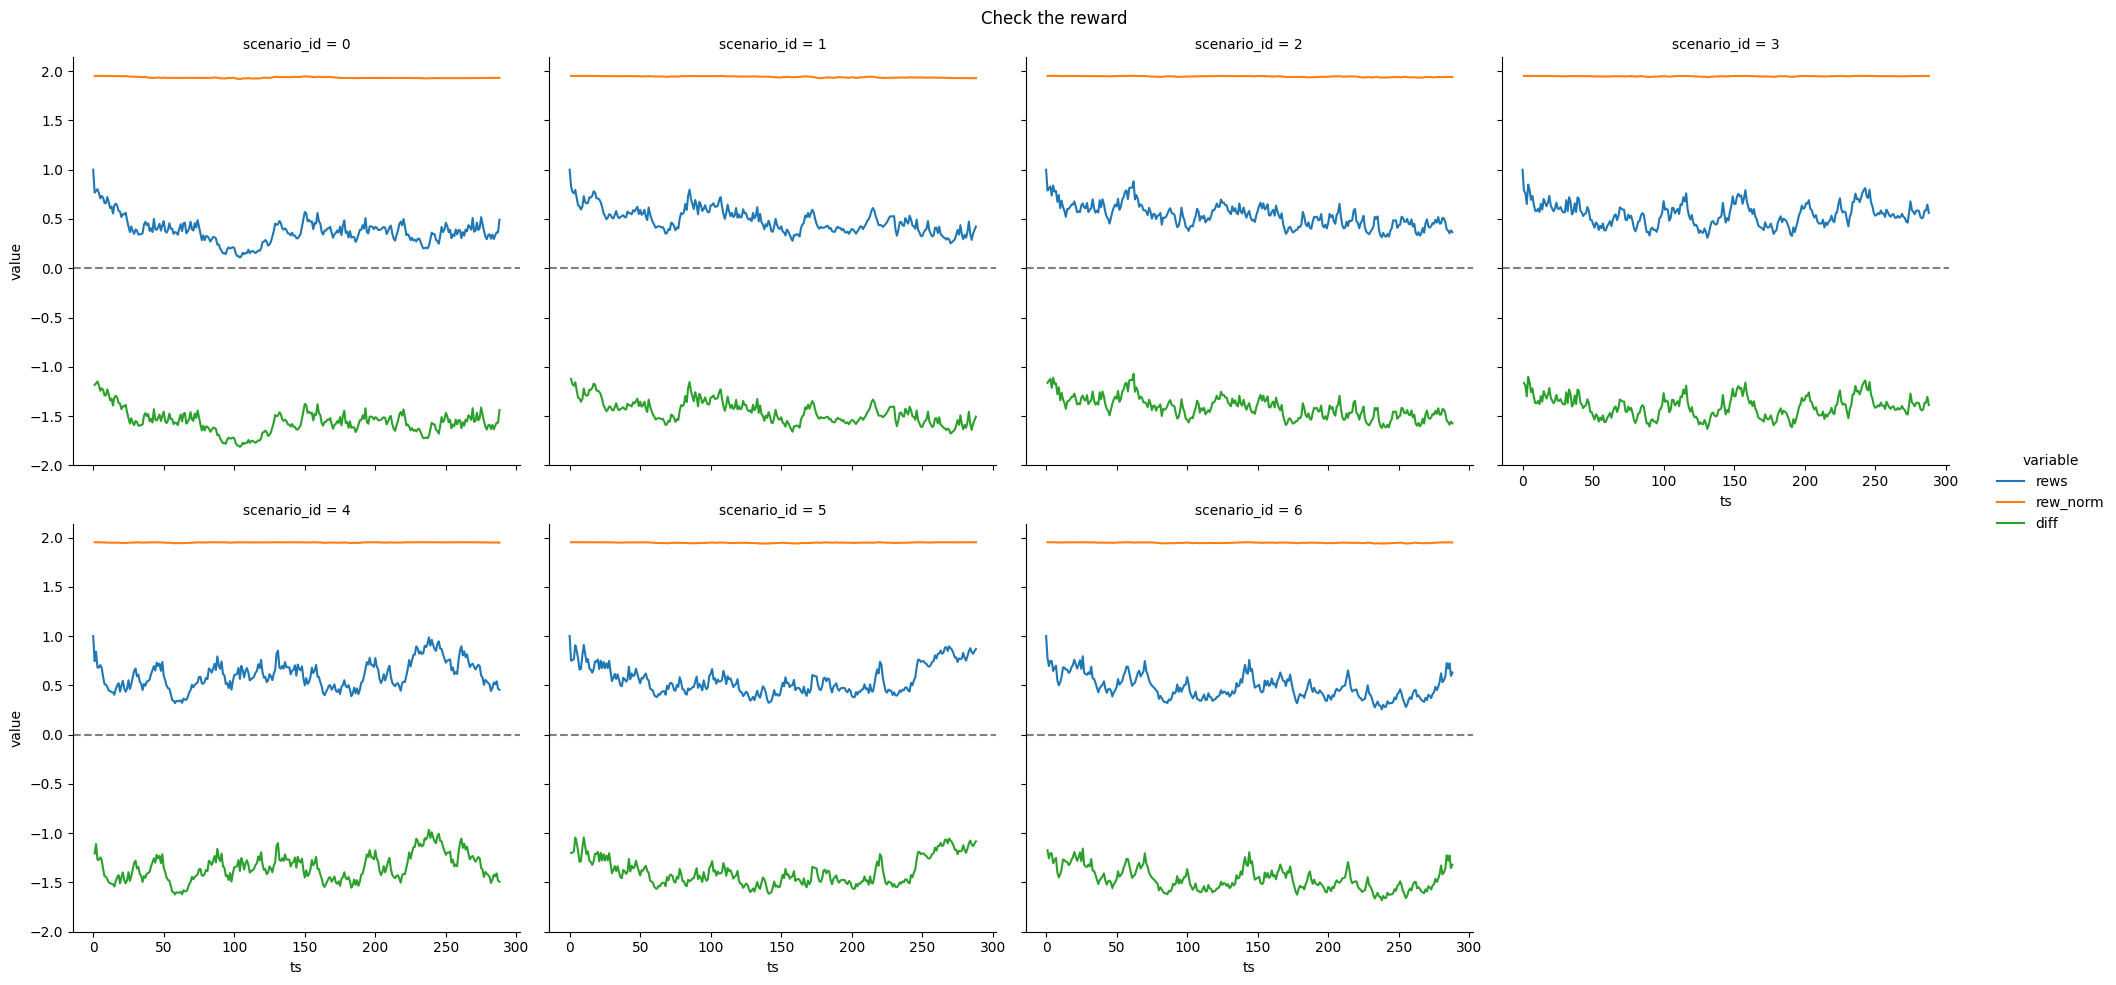

In [30]:
df = data_w.copy()
df["penalty"] = 20-4*((df["storage_charge_norm_0"] - df["storage_setpoint_0"].shift(1))**2 + (df["storage_charge_norm_1"] - df["storage_setpoint_1"].shift(1))**2)/env.n_storage
rew_min, rew_max = - 20, 1
df["rew_norm"] = (1 + df["penalty"] - rew_min)/(rew_max - rew_min)
df["diff"] = df["rews"] - df["rew_norm"]
df = pd.melt(df, id_vars=["ts", "scenario_id"], value_vars=["rews", "rew_norm", "diff"]) #, "rews_bu"])
g = sns.relplot(df, x="ts", y="value", hue="variable", kind="line", col="scenario_id", col_wrap=4)
g.fig.suptitle("Check the reward")
g.refline(y=0, ls = "--", color="grey")

# df = data_w.copy()
# df["penalty"] = -agent.l2rpn_agent.gymenv.alpha*((df["storage_charge_norm_0"] - df["storage_setpoint_0"].shift(1))**2 + (df["storage_charge_norm_1"] - df["storage_setpoint_1"].shift(1))**2)/env.n_storage
# g = sns.relplot(df, x="ts", y="penalty", kind="line")
# g.fig.suptitle("Check the reward")


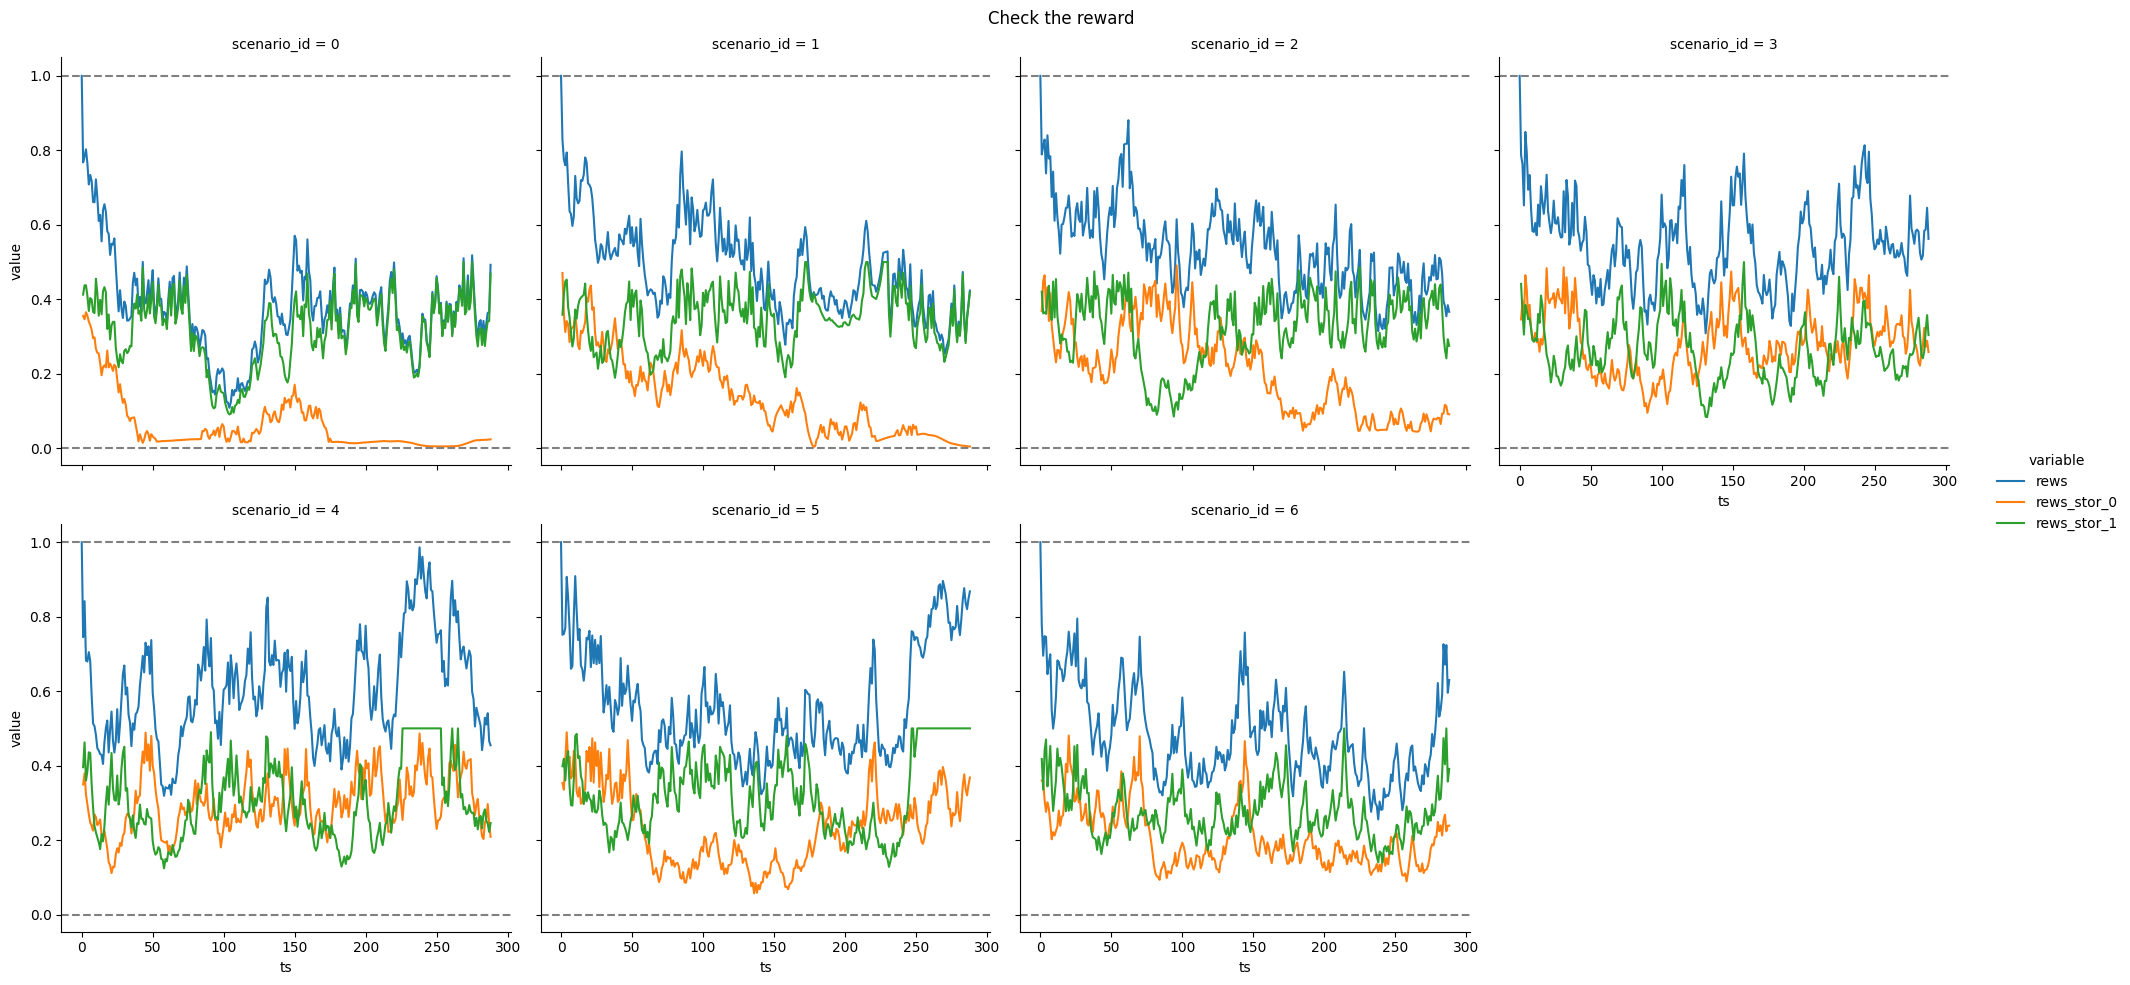

In [35]:
df = data_w.copy()
df = df.sort_values(["scenario_id", "ts"])
df["storage_setpoint_prev_0"] = df.groupby(["scenario_id"])["storage_setpoint_0"].shift()
df["storage_setpoint_prev_1"] = df.groupby(["scenario_id"])["storage_setpoint_1"].shift()
ind = gym_env.ind
k = 1/(0.5)**ind
# df["rews_calc"] = 1 - k * (np.power(np.abs(df["storage_charge_norm_0"] - df["storage_setpoint_prev_0"]), ind) + np.power(np.abs(df["storage_charge_norm_1"] - df["storage_setpoint_prev_1"]), ind))/env.n_storage
df["rews_stor_0"] = 0.5 - k * np.abs(df["storage_charge_norm_0"] - df["storage_setpoint_prev_0"])**ind/env.n_storage
df["rews_stor_1"] = 0.5 - k * np.abs(df["storage_charge_norm_1"] - df["storage_setpoint_prev_1"])**ind/env.n_storage
df = pd.melt(df, id_vars=["ts", "scenario_id"], value_vars=["rews", "rews_stor_0", "rews_stor_1"])
g = sns.relplot(df, x="ts", y="value", hue="variable", kind="line", col="scenario_id", col_wrap=4)
g.fig.suptitle("Check the reward")
g.refline(y=0, ls = "--", color="grey")
g.refline(y=1, ls = "--", color="grey")

# df = data_w.copy()
# df["penalty"] = -agent.l2rpn_agent.gymenv.alpha*((df["storage_charge_norm_0"] - df["storage_setpoint_0"].shift(1))**2 + (df["storage_charge_norm_1"] - df["storage_setpoint_1"].shift(1))**2)/env.n_storage
# g = sns.relplot(df, x="ts", y="penalty", kind="line")
# g.fig.suptitle("Check the reward")

In [32]:
g = px.line(data, x = "ts", y = ["storage_charge_norm", "storage_setpoint"], facet_col="stor_id", facet_row="scenario_id",
    height=1400
    )
g.update_layout(yaxis_title='storage_capacity')
g.update_layout(yaxis_range=[-0.01, 1.01])
# g.add_hline(y=0, line_width=2, line_dash="dash", line_color="grey")
g.show()

In [33]:
g = px.line(data, x = "ts", y = ["set_storage_norm"], facet_col="stor_id", facet_row="scenario_id",
    height=1400
    )
# g.update_layout(yaxis_title='storage_power')
g.update_layout(yaxis_range=[-1.01,1.01])
g.add_hline(y=0, line_width=2, line_dash="dash", line_color="grey")
g.show()